<center><font size = "10"> Week 3 - Ion Channels <center>
<center><font size = "8">Tutorial 01: data files<center>

<font size = "3"><font color = "blue">In this tutorial you will learn:
    
<font size = "3"><font color = "blue">- To use and explore ion channel files 

<font size = "3"><font color = "blue">- To plot data from ion channel files
    
<font size = "3"><font color = "blue">- To fit curves to data 
    
Ion channels are proteins situated on the membrane of a cell.
When they open, they allow one (sometimes more than one) kind of ion to pass through the cell's membrane.
Together, the 1) membrane potential, 2) the concentration of that ion type inside and outside the cell, and 3) the ion's charge, determine whether ions of that type flow into or out of the cell, creating a current and changing the cell's membrane potential.
    
Ion channels come in many varieties and for many their opening and closing is dictated by particular circumstances, such as the membrane potential, chemical processes internal to the cell, or the binding of a neurotransmitter to the ion channel.
    
In this tutorial we will see data on the current traversing the membrane of a neuron from a patch-clamp experiment.


## 1. Open ion channel data files and plot 

<font size = "3">Take a look at the data files from this tutorial with the extension .NWB (Neurodata Without Borders). This is a specific format for storing cellular-based neurophysiology data from a single experimental session (you can find more information [here](https://nwb-schema.readthedocs.io/en/latest/)).
    
<font size = "3">There is a specialized python package for loading this file type: [PyNWB](https://pynwb.readthedocs.io/en/stable/). Since .nwb files are a form of hdf5 file, they can also be visualized with [HDFview](https://www.hdfgroup.org/downloads/hdfview/) and opened in python with [h5py](https://docs.h5py.org/en/stable/quick.html). You can see below an example of one of the files opened in HDFview.

 <br><img src="HDFViewer_IonFileDisplay.png" width="800" height="400">   


In this tutorial we will use h5py, as pyNWB is not installed on noto.
Now let's see how to open and explore the file with Python
  
    
A h5py.File object can be treated as a dict. It's values can be HDF5 group objects, which also act like dicts, or HDF5 dataset objects, which act like arrays.

In [2]:
!pip install h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.8 MB/s eta 0:00:00a 0:00:01


In [3]:
# Open data with python
import h5py
import pandas as pd

data_path = 'Data_files/rCell2148.nwb'

data = h5py.File(data_path, 'r')
print(data.keys())
print(data['session_description'][0])

<KeysViewHDF5 ['acquisition', 'analysis', 'checksums', 'epochs', 'file_create_date', 'general', 'identifier', 'nwb_version', 'processing', 'session_description', 'session_start_time', 'stimulus']>
b'2 exp with Kv1.1'


Below we visualize some of the ion channel current data.

Activation, Inactivation, Deactivation and Ramp are stimulation protocols applied to the cell to see how its ion channels respond.

Refer to slide 41 of the lecture for the different protocols. For more information, you can look [here](http://www.physiologymodels.info/w3/NEW_Electrophysiology/index.htm#)

Each trace we plot below represents current flow through the ion channel during one of these protocols (averaged over many trials: individual trials are more stochastic due to the stochastic opening/closing of ion channels).
Note that a positive current carries charge out of the cell, leading to the membrane potential hyperpolarizing (becoming more negative).
Because this current is hyperpolarizing, and has delays in activation and deactivation, and does not inactivate, we know we are looking at a potassium channel.

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def plot_timeseries(timeseries_repetition):
    traces = np.array(timeseries_repetition['data']).transpose()
    if 'x_interval' in timeseries_repetition:
        dts = np.array(timeseries_repetition['x_interval'])
    else:
        dts = np.array((len(traces), ))
    fig = plt.figure()
    for trace, dt in zip(traces, dts):
        time = np.linspace(0, len(trace) * dt, len(trace))
        plt.plot(time, trace) #label=label)

    plt.title(timeseries_repetition.name)
    plt.xlabel("Time (s)")
    plt.ylabel("Current (pA)")
        

def plot_recurse(group):
    for k, grp in group.items():
        if hasattr(grp, 'items'):
            if 'data' in grp:
                plot_timeseries(grp)
            else:
                plot_recurse(grp)


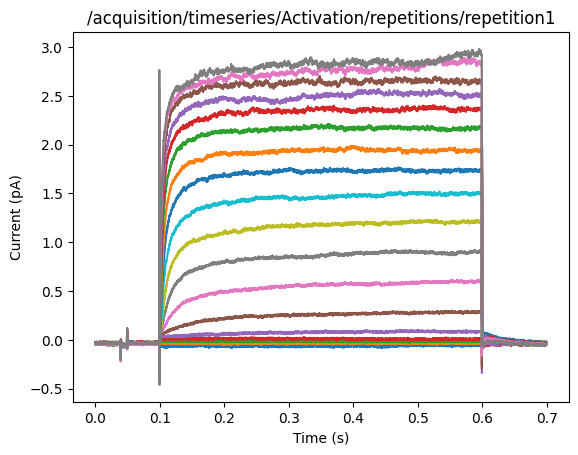

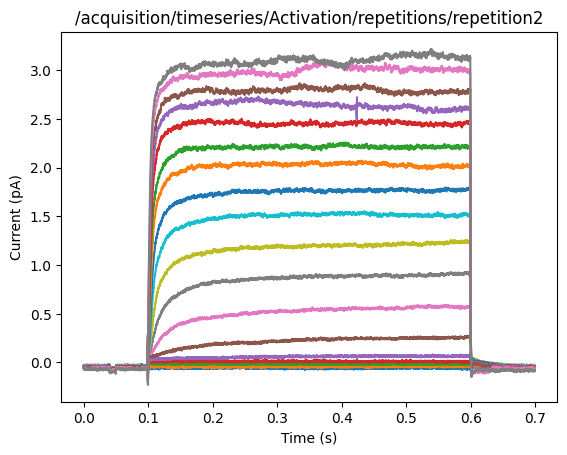

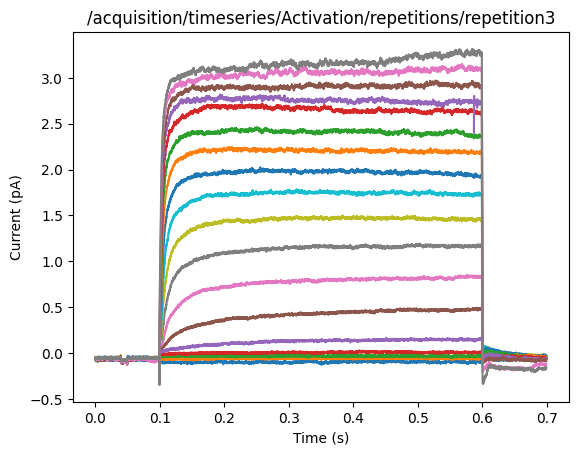

In [5]:
plot_recurse(data['acquisition']['timeseries']['Activation'])

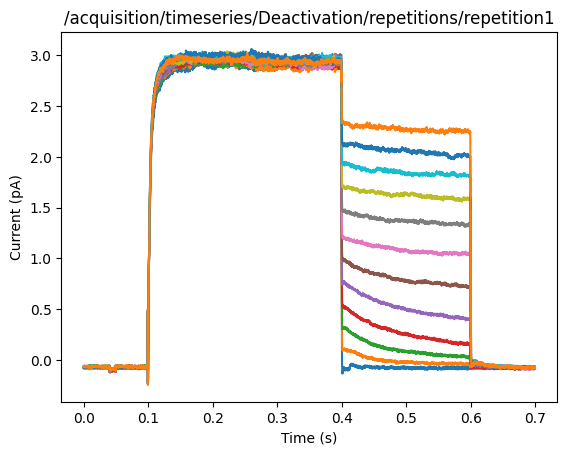

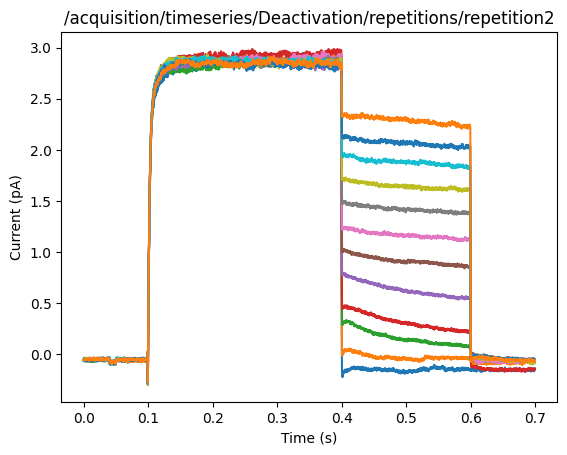

In [6]:
plot_recurse(data['acquisition']['timeseries']['Deactivation'])

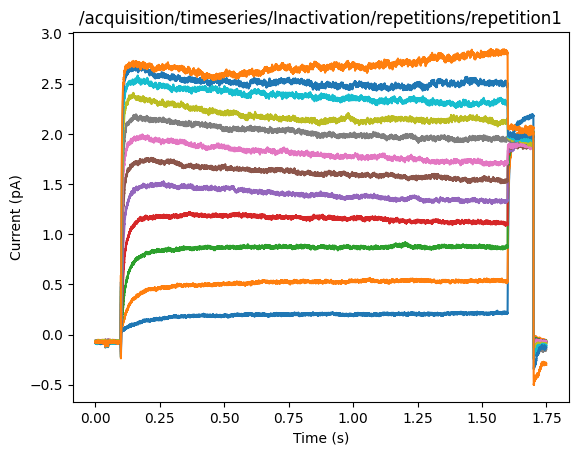

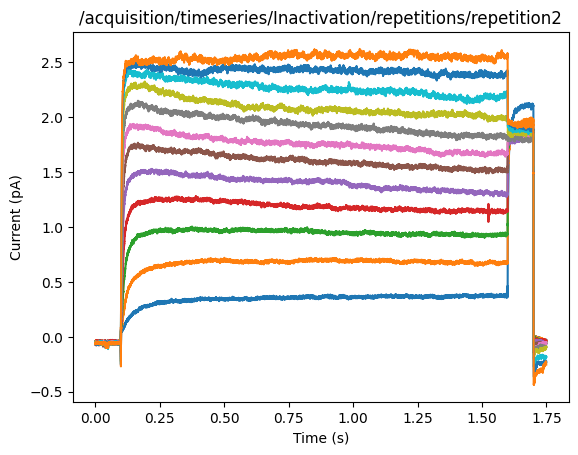

In [7]:
plot_recurse(data['acquisition']['timeseries']['Inactivation'])

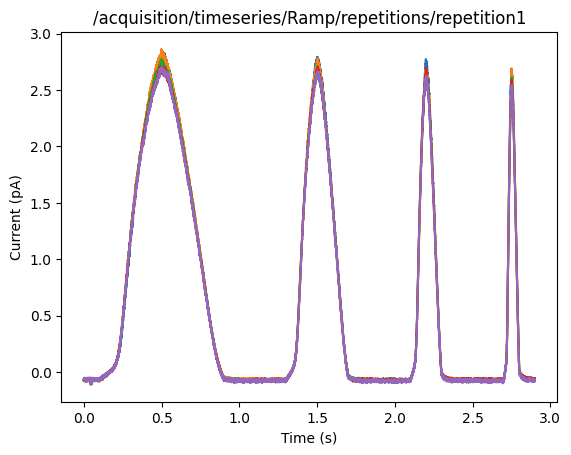

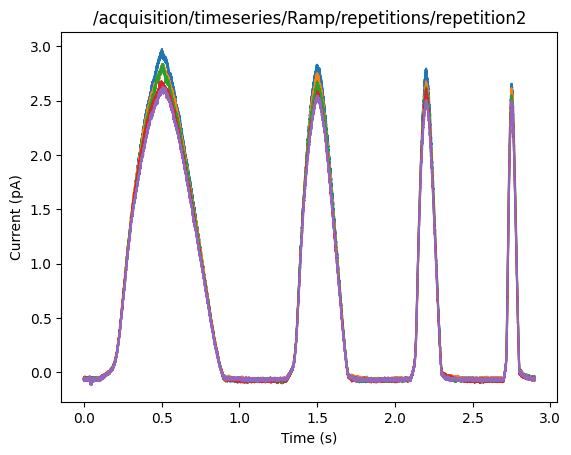

In [8]:
plot_recurse(data['acquisition']['timeseries']['Ramp'])

# 3. Curve fitting

In order to model the dynamics of transmembrane ionic currents accurately, we need experimental data to constrain the parameters of our ion channel models.

Below are some examples of fitting functions to data in python.

### Example 1: linear fitting

In [9]:
dat1_path = 'Data_files/stLine1.dat'
dat2_path = 'Data_files/stLine2.dat'
dat3_path = 'Data_files/stLine3.dat'

In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def plot_linear_regression(fileName, fitting_values = False):
    '''This function computes a linear regression for the data in fileName'''
    # Open the file and separate the columns in x and y
    df = pd.read_table(fileName, sep='\s+', header=None)
    x = df[0]
    y = df[1]
    
    # Fitting function
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y) 
    # y = gradient*x + intercept
    # gradient = slope of the regression line; float
    # intercept = intercept of the regression line; float
    # r_value = correlation coefficient; float
    # p_value = two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero; float
    # std_err = standard error of the estimated gradient; float
    
    # Print fitting parameters result, if we want
    # Gradient and intercept are the parameters to be computed
    # You can quantify the quality of the fitting
    # by comparing r, p and std
    if fitting_values == True:
        print ('gradient =', gradient)
        print ('intercept =', intercept)
        print ('r_value =', r_value)
        print ('p_value =', p_value)
        print ('std_err =', std_err)
    
    # Prepare predicted line for plotting 
    mn=np.min(x)
    mx=np.max(x)
    x1=np.linspace(mn,mx,500)
    y1=gradient*x1+intercept
    
    # Plot data and regresion line
    plt.plot(x,y,'xk', x1, y1, '-r')
    plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_5279/3129754059.py:9: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table(fileName, sep='\s+', header=None)


gradient = 1.596956190769818
intercept = 6.094402329070003
r_value = 0.9996306363152068
p_value = 2.865307312432146e-155
std_err = 0.004385735081414165


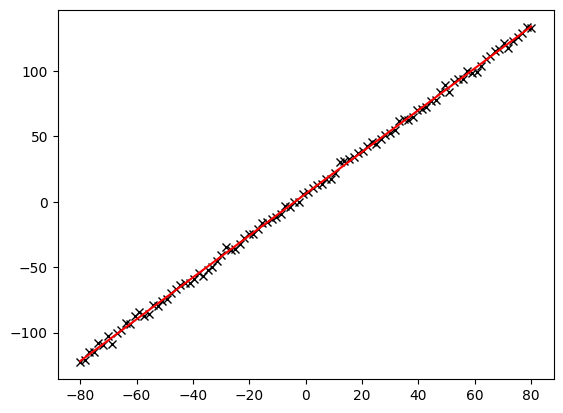

gradient = 1.6234965279685152
intercept = 6.949301981950003
r_value = 0.9926875523701365
p_value = 8.316474028522387e-92
std_err = 0.01994236857030694


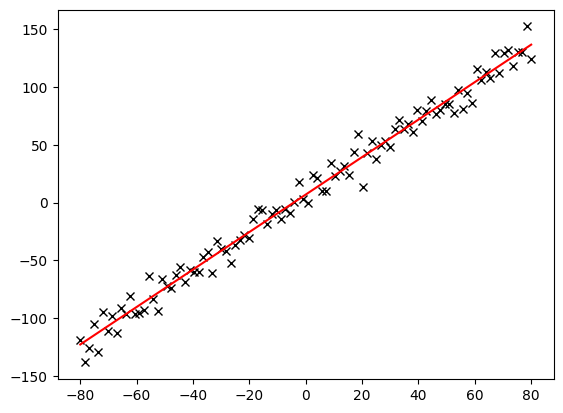

gradient = 1.6176743614743614
intercept = 7.389658294700001
r_value = 0.9707253874375767
p_value = 1.6315611874305984e-62
std_err = 0.040433404483008174


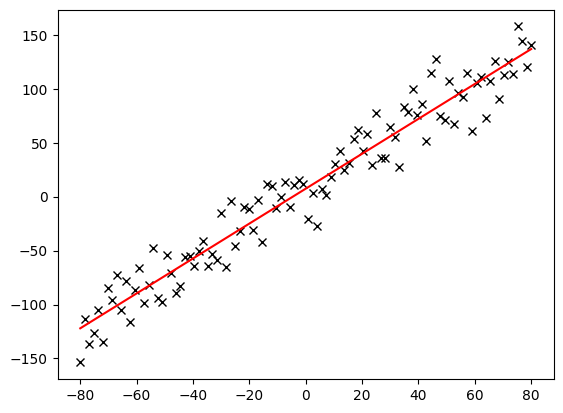

In [11]:
plot_linear_regression(dat1_path, fitting_values=True)
plot_linear_regression(dat2_path, fitting_values=True)
plot_linear_regression(dat3_path, fitting_values=True)

### Example 2: exponential fitting

The `scipy.optimize.curve_fit` method is very handy for fitting arbitrary functions to data.

From time to time it can fail to fit and provide invalid numbers. Some strategies to address that include providing initial estimates or boundaries for parameters.
Check the scipy documentation if you need to do so.

In [12]:
dat4_path = 'Data_files/singleExp1.dat'
dat5_path = 'Data_files/singleExp2.dat'
dat6_path = 'Data_files/singleExp3.dat'

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def func_exp(x, tau):
    return 1 - np.exp(-x/tau)

def plot_exponential_fit(file_name):
    '''Fit an exponential function to the data in file_name and plot the result.'''
    # Open the file and separate the columns in x and y
    df = pd.read_table(file_name, sep='\s+', header=None)
    x_data = df[0]
    y_data = df[1]
    
    # In this case, we want to compute TAU = popt[0]
    # and to quantify the fitting quality we want to know perr
    popt, pcov = curve_fit(func_exp, x_data, y_data)
    perr = np.sqrt(np.diag(pcov))
    
    plt.figure(figsize=(10,6))
    plt.plot(x_data, y_data, 'xk', label='original data' )
    plt.plot(x_data, func_exp(x_data, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))
    plt.legend()
    plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_5279/845431697.py:13: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table(file_name, sep='\s+', header=None)


/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_5279/845431697.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(x_data, func_exp(x_data, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))


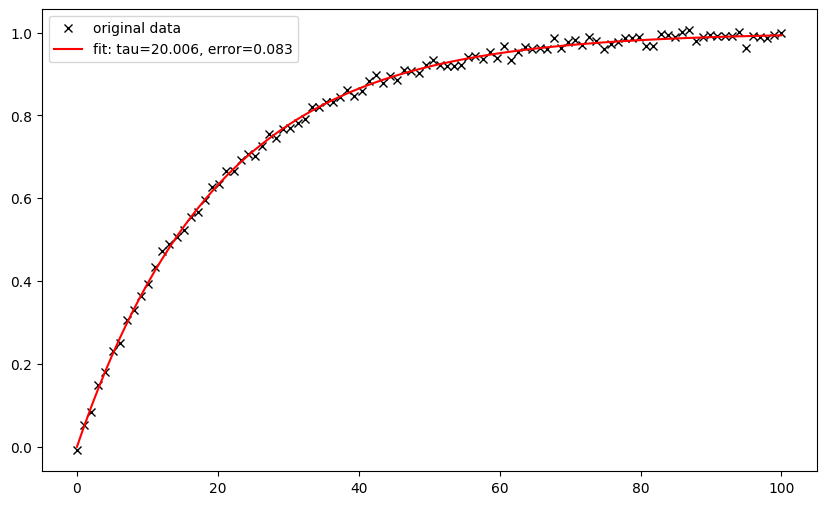

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_5279/845431697.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(x_data, func_exp(x_data, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))


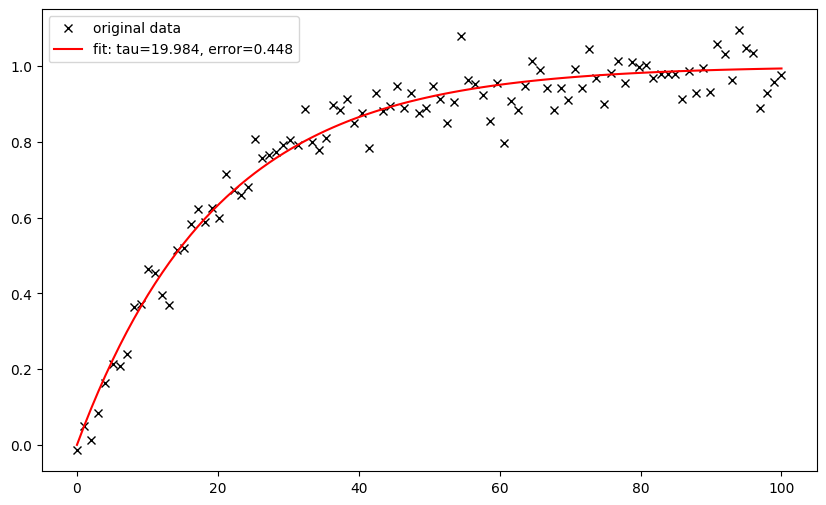

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_5279/845431697.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(x_data, func_exp(x_data, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))


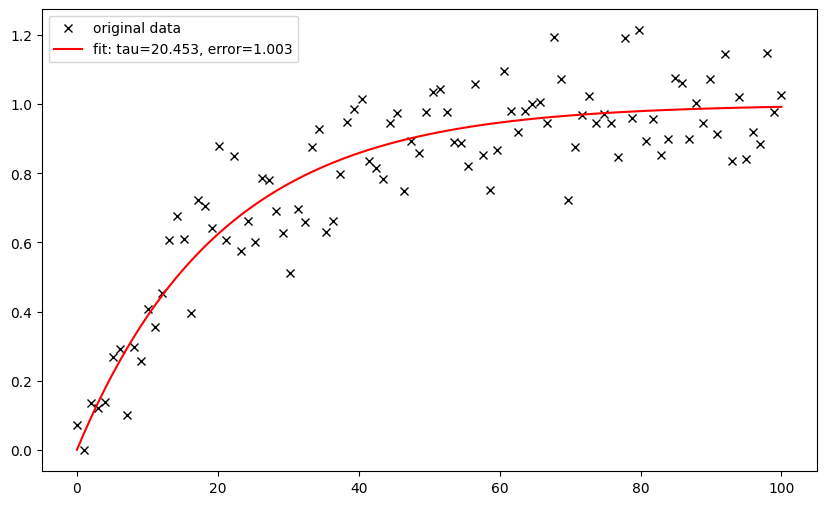

In [14]:
plot_exponential_fit(dat4_path)
plot_exponential_fit(dat5_path)
plot_exponential_fit(dat6_path)